In [1]:
pip install ..

Processing /home/wasit/github/myocr
  Preparing metadata (setup.py) ... done
  Created wheel for myocr: filename=myocr-0.1.0-py3-none-any.whl size=11387 sha256=5889ffcd50fec6b0f6c1f37f505525f2c27f95126efb0b1a19201cfb9f6eefbd
  Stored in directory: /tmp/pip-ephem-wheel-cache-8evvh1xz/wheels/be/3f/96/68d85e1c9519abe32211d6816db40e44a48227680f808e7523
Successfully built myocr
  Attempting uninstall: myocr
    Found existing installation: myocr 0.1.0
    Uninstalling myocr-0.1.0:
      Successfully uninstalled myocr-0.1.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
# pip install pandas

In [3]:
!pip freeze | grep pandas

pandas==2.2.3


# Create a new Project

In [4]:
from myocr import Project
debug=False
project_name ='myproject'
my_class={
    0:'miss',
    1:'check',
    2:'cancel'
}
p=Project(project_name,my_class)



Initializing project:
Project 'myproject' already exists with ID: 2
<View>
    <Image name="image" value="$image" />
    <Choices name="choice" toName="image" showInLine="true">
        <Choice value="miss" /><Choice value="check" /><Choice value="cancel" /></Choices>
</View>
Data deserialized and cast to original types from myproject/config.json
Project config:
{'cropped_dir': PosixPath('/home/wasit/github/myocr/image-server/dataset/images/myproject'),
 'landing_dir': PosixPath('/home/wasit/github/myocr/notebooks/myproject/_landing'),
 'project_name': 'myproject',
 'staging_dir': PosixPath('/home/wasit/github/myocr/notebooks/myproject/_staging')}


# Register all landing images

In [5]:
ref_path='ref.png'
reference_image = p.set_reference_image('ref.png')
p.register_image(debug)


Register_image:
/home/wasit/github/myocr/notebooks/myproject/_landing/input1.jpg
/home/wasit/github/myocr/notebooks/myproject/_staging/input1.jpg


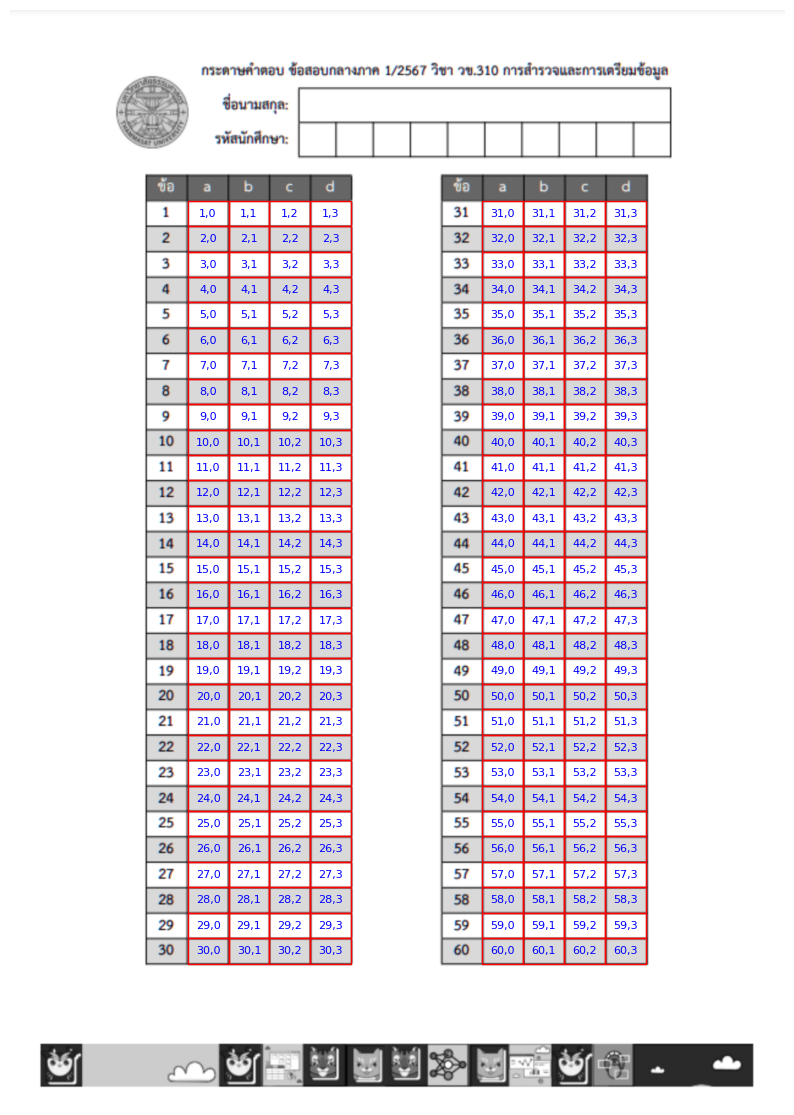

In [6]:
# Define the bounding box dimensions
box_width = 33.5*2  # approximate width of each choice box
box_height = 20.8*2  # approximate height of each question row

# Coordinates for the left column (questions 1-30)
left_column_start_x = 145*2
left_column_start_y = 156*2

# Coordinates for the right column (questions 31-60)
right_column_start_x = 386*2
right_column_start_y = 156*2

all_bbox=[]   
    
# Draw bounding boxes for the left column (questions 1-30)
for i in range(30):
    for c, choice in enumerate(['a', 'b', 'c', 'd']):
        q=i+1
        x = left_column_start_x + c * box_width  # Each choice moves right by box_width
        y = left_column_start_y + i * box_height  # Each question moves down by box_height
        d={
            'q':q,
            'c':c,
            'x':x,
            'y':y,
            'box_width': box_width, 
            'box_height': box_height
        }
        all_bbox.append(d)
        # print(d)
        # save_cropped_bbox(image,sheet_name, q + 1, choice, x, y, box_width, box_height)

# Draw bounding boxes for the right column (questions 31-60)
for i in range(30):
    for c, choice in enumerate(['a', 'b', 'c', 'd']):
        q=i+31
        x = right_column_start_x + c * box_width  # Each choice moves right by box_width
        y = right_column_start_y + i* box_height  # Each question moves down by box_height
        d={
            'q':q,
            'c':c,
            'x':x,
            'y':y,
            'box_width': box_width, 
            'box_height': box_height
        }
        all_bbox.append(d)
        # print(d)
        # save_cropped_bbox(image,sheet_name, q + 1, choice, x, y, box_width, box_height)
    
p.draw_all_bbox(reference_image,all_bbox)

In [7]:
p.extract_bb(all_bbox,debug)


Extract_image:
image_path:  /home/wasit/github/myocr/notebooks/myproject/_staging/input1.jpg
sheet_name:  input1
bbox:  [{'q': 1, 'c': 0, 'x': 290.0, 'y': 312.0, 'box_width': 67.0, 'box_height': 41.6, 's': 'input1'}, {'q


# Forward

In [8]:
import torchvision.transforms as transforms
from myocr import ImageClassifier
from pathlib import Path
import pandas as pd

num_classes=len(p.my_class)

input_image_size = (32, 32)
transform = transforms.Compose([
    transforms.Resize(input_image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
model_name='lenet'
classifier = ImageClassifier(model_name, num_classes, input_image_size, transform)

pre_train = 'lenet_model_6960.pth'
if Path(pre_train).exists():
    classifier.load(pre_train)

def as_series(func):
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        return pd.Series(result)
    return wrapper
    
@as_series
def forward(image):
    class_id, confidence = classifier.predict(image)
    return class_id, confidence

# Apply the function to each row and create 'y1' and 'y2' columns
df = p.get_input_df()
df[['predict', 'confidence']] = df.apply(lambda row: forward(row['PIL_image']), axis=1)
df.info()
df[df['confidence']<0.95]

Model and hyperparameters loaded from lenet_model_6960.pth


/home/wasit/miniconda3/envs/myocr/lib/python3.10/site-packages/myocr/vision.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   project_name  240 non-null    object 
 1   image_file    240 non-null    object 
 2   sheet         240 non-null    object 
 3   choice        240 non-null    object 
 4   PIL_image     240 non-null    object 
 5   image_url     240 non-null    object 
 6   predict       240 non-null    float64
 7   confidence    240 non-null    float64
dtypes: float64(2), object(6)
memory usage: 15.1+ KB


,project_name,image_file,sheet,choice,PIL_image,image_url,predict,confidence
2,myproject,B_input1_28_0.jpg,input1,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,http://localhost:8000/myproject/B_input1_28_0.jpg,0.0,0.629554
71,myproject,B_input1_21_2.jpg,input1,2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,http://localhost:8000/myproject/B_input1_21_2.jpg,1.0,0.707662
94,myproject,B_input1_30_0.jpg,input1,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,http://localhost:8000/myproject/B_input1_30_0.jpg,0.0,0.864823


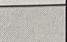

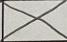

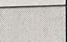

In [9]:
from IPython.display import display

# Loop over the rows where 'confidence' is less than 0.5
for _, row in df[df['confidence'] < 0.9].loc[:, ['PIL_image']].iterrows():
    # 'row' contains the row data, extract 'PIL_image'
    display(row['PIL_image'])  # This will display the PIL image

In [10]:
# columns=['image_file','sheet','choice','predict','confidence']
# df[columns].to_parquet('results.parquet')

# Create Task

In [11]:
p.create_task(forward)

No new image found


# Train

In [12]:
df_complete_task=p.lb.fetch_labels_from_label_studio()
# df_complete_task['image_file']=df_complete_task['image_url'].apply(lambda x: x.replace(lb.IMAGE_SERVER_URL+project_name+'/',''))
df_complete_task.info()
df_complete_task.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   task_id     240 non-null    int64 
 1   class_id    240 non-null    int64 
 2   class_name  240 non-null    object
 3   image_url   240 non-null    object
 4   image_file  240 non-null    object
dtypes: int64(2), object(3)
memory usage: 9.5+ KB


,task_id,class_id,class_name,image_url,image_file
0,241,0,miss,http://localhost:8000/myproject/B_input1_41_2.jpg,B_input1_41_2.jpg
1,242,0,miss,http://localhost:8000/myproject/B_input1_26_0.jpg,B_input1_26_0.jpg
2,243,0,miss,http://localhost:8000/myproject/B_input1_28_0.jpg,B_input1_28_0.jpg
3,244,0,miss,http://localhost:8000/myproject/B_input1_50_0.jpg,B_input1_50_0.jpg
4,245,0,miss,http://localhost:8000/myproject/B_input1_6_1.jpg,B_input1_6_1.jpg


Annotations saved to 'annotations.json'.


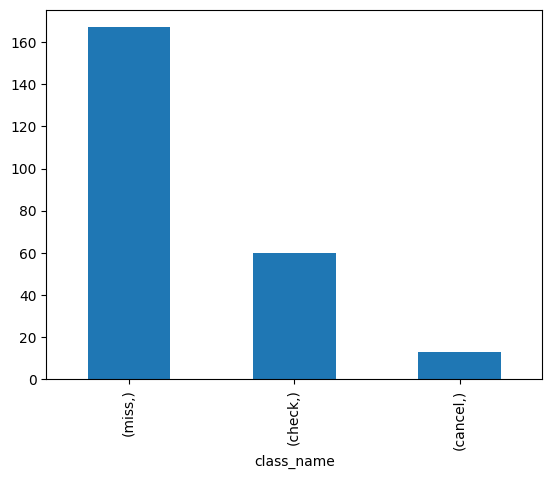

In [14]:
import json
df_complete_task[[ 'class_name']].value_counts().plot(kind='bar')
columns=['image_file','class_id']
annotation = {
    'annotations':df_complete_task[columns].to_dict('records'),
    'class_names':my_class
}
with open('annotations.json', 'w') as json_file:
    json.dump(annotation, json_file, indent=4)

print("Annotations saved to 'annotations.json'.")

In [16]:
from myocr import load_data
# Example Usage
annotations_file = 'annotations.json'  # Path to the JSON file with annotations
img_dir = p.cropped_dir  # Directory where the images are stored


augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

# Load the data with a custom train-test split, random seed, and data augmentation
train_loader, test_loader = load_data(annotations_file, img_dir, transform, augmentations, train_ratio=0.8, random_seed=42, batch_size=32)

# Train the model
classifier.train(train_loader, epochs=100)

# Evaluate the model
classifier.evaluate(test_loader)

# Save the model
classifier.save('lenet_model.pth')

Epoch [1/100], Loss: 0.2314
Epoch [11/100], Loss: 0.0527
Epoch [21/100], Loss: 0.0210
Epoch [31/100], Loss: 0.0224
Epoch [41/100], Loss: 0.0032
Epoch [51/100], Loss: 0.0019
Epoch [61/100], Loss: 0.0032
Epoch [71/100], Loss: 0.0211
Epoch [81/100], Loss: 0.1571
Epoch [91/100], Loss: 0.0035
Accuracy: 100.00%
Model and hyperparameters saved to lenet_model.pth
